# **Regressão Logística - pt. II**

Agora que já aprendemos a ajustar uma regressão logística a um conjunto de dados, podemos aprofundar a nossa análise para entender como o limite mínimo de probabilidade altera os resultados.

Primeiramente, vamos realizar a modelagem novamente e estimar as probabilidades, dessa vez:

In [45]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, \
                            precision_score, recall_score, precision_recall_curve, \
                            roc_curve, roc_auc_score

# ignorar warnings
warnings.filterwarnings('ignore')

In [2]:
# montando drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# procurando arquivos no Drive
data = pd.read_csv('/content/drive/MyDrive/Bootcamp_DataScience/Algoritmos de Inteligência Artificial para Classificação/datasets/german_credit.csv')
data.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [5]:
# modificando os nomes das colunas
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [6]:
# para iniciar nosso trabalho, vamos começar selecionando apenas as variáveis numéricas
cols = ['duration_of_credit_(month)', 'credit_amount', 'age_(years)', 'creditability',
        'concurrent_credits', 'length_of_current_employment', 'no_of_dependents']
data = data[cols]

In [7]:
# separando x e y
x = data.drop(['creditability'], axis=1)
y = data[['creditability']]

In [8]:
# separando treino e teste - com estratificação
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [9]:
# criando um pipeline de modelagem
pipe_rl = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('rl2', LogisticRegression(penalty=None))
])

# ajustando o pipeline
pipe_rl.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rl2', LogisticRegression(penalty=None))])

Normalmente, usamos o método `.predict()` para obter as classes que cada uma das amostras pertence.

No entanto, podemos usar também o método `.predict_proba()` para obter as estimativas de probabilidade de pertencimento.

In [11]:
# vamos analisar a primeira linha do conjunto de teste
row = x_test.iloc[[0], :]
row

,duration_of_credit_(month),credit_amount,age_(years),concurrent_credits,length_of_current_employment,no_of_dependents
898,27,3915,36,3,3,2


In [12]:
# analisando as probabilidades
probs = pipe_rl.predict_proba(row)
probs

array([[0.34217375, 0.65782625]])

No caso acima, a classe escolhida seria a classe 1, visto que sua probabilidade de pertecimento é maior.

A probabilidade mínima para pertencer a uma classe é 0.5, por padrão. No entanto, podemos modificar esse limiar, conforme as necessidades do nosso negócio.

- se $p_{decision} > 0.5 \to$ dizemos que o modelo se torna mais **conservador**, pois será necessária uma "certeza maior" para que um ponto pertença a uma classe. Como efeito colateral, teremos um aumento de falsos negativos.

- se $p_{decision} < 0.5 \to$ dizemos que o modelo se torna mais **liberal**, pois será necessária uma "certeza menor" para que um ponto pertença a uma classe. Como efeito colateral, teremos um aumento de falsos positivos.

Façamos uma análise gráfica desse efeito:

In [23]:
# criando um vetor de probabilidades
prob_min = np.linspace(0.01, 0.99, 99)

# realizando a previsão das probabilidades de toda base de teste
prob_test = pipe_rl.predict_proba(x_test)

FP = []
FN = []

for p in prob_min:

  # calculando o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # calculando a matriz de confusão
  mc = confusion_matrix(y_test, yhat)

  # alimentar as listas
  FP.append(mc[0, 1] / y_test.shape[0])
  FN.append(mc[1, 0] / y_test.shape[0])

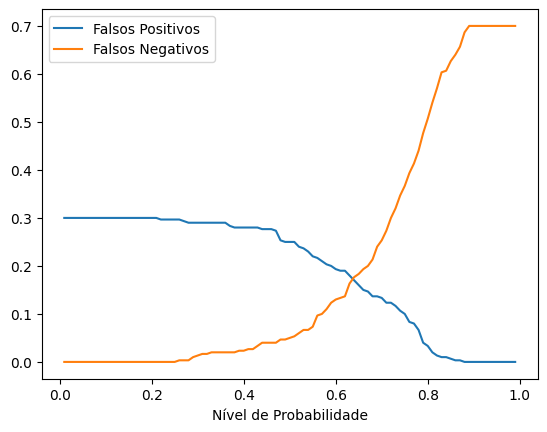

In [24]:
plt.plot(prob_min, FP, label='Falsos Positivos')
plt.plot(prob_min, FN, label='Falsos Negativos')
plt.xlabel('Nível de Probabilidade')
plt.legend()
plt.show()

Podemos olhar esses resultados em termos de métricas bem conhecidas:

- **Gráfico Recall x Precisão**
- **Curva ROC** - curva que plota a Taxa de Verdadeiros Positivos (TPR) contra a Taxa de Falsos Positivos (FPR)

In [39]:
precision = []
recall = []

for p in prob_min:

  # calculando o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # alimentar as listas
  precision.append(precision_score(y_test, yhat))
  recall.append(recall_score(y_test, yhat))

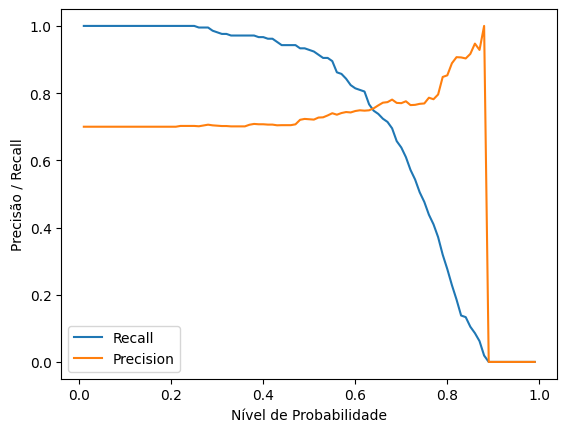

In [40]:
plt.plot(prob_min, recall, label='Recall')
plt.plot(prob_min, precision, label='Precision')
plt.xlabel('Nível de Probabilidade')
plt.ylabel('Precisão / Recall')
plt.legend()
plt.show()

In [41]:
precision, recall, _ = precision_recall_curve(y_test, [c[1] for c in prob_test])

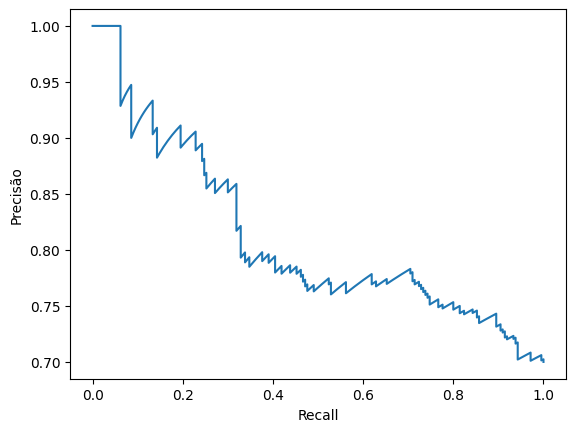

In [42]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

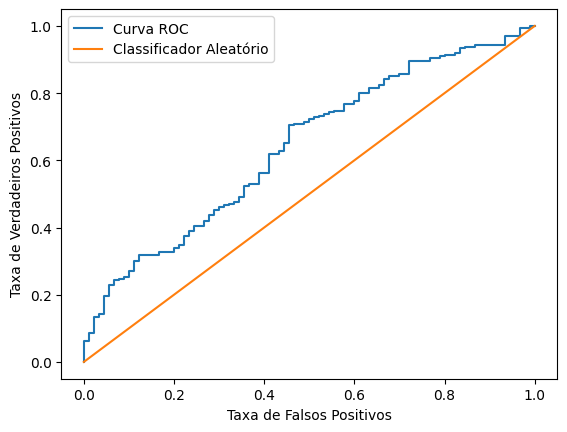

In [47]:
fpr, tpr, _ = roc_curve(y_test, [c[1] for c in prob_test])

plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], label='Classificador Aleatório')
plt.legend()
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.show()

In [48]:
# outra métrica de avaliação - relacionada com a variância do modelo
print('Área abaixo da curva AUC ROC:', roc_auc_score(y_test, [c[1] for c in prob_test]))

Área abaixo da curva AUC ROC: 0.6403174603174603


Por último, vamos adotar uma postura mais voltada aos negócios, considerando o lucro médio de cada cliente que foi classificado:

In [25]:
def customer_cost(yreal, ypred):

  # calcula a matriz de confusão
  conf_matrix = confusion_matrix(yreal, ypred)

  # extrai pontuações
  TP = conf_matrix[1, 1]  # Verdadeiros positivos
  FP = conf_matrix[0, 1]  # Falsos positivos
  TN = conf_matrix[0, 0]  # Verdadeiros negativos
  FN = conf_matrix[1, 0]  # Falsos negativos

  # calcula custo
  return ((50 * TP) + (-5 * FN) + (-5 * TN) + (-150 * FP)) / yreal.shape[0]

In [26]:
cost = []

for p in prob_min:

  # calculando o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # alimentar as listas
  cost.append(customer_cost(y_test, yhat))

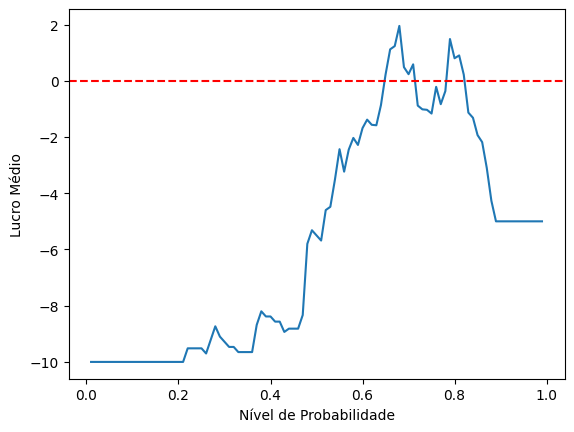

In [29]:
plt.plot(prob_min, cost, label='Lucro Médio')
plt.ylabel('Lucro Médio')
plt.xlabel('Nível de Probabilidade')
plt.axhline(y=0, color='red', ls='--')
plt.show()